Credit for helping me get the data set loaded in: https://www.kaggle.com/code/mauricioasperti/cats-vs-dogs-image-classification/notebook

Credit for helping me figure out how to find the distribution of target classes: https://stackoverflow.com/questions/60876805/how-to-show-the-class-distribution-in-dataset-object-in-tensorflow/60877708#60877708

# **Imports**

In [5]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# **Loading in the data set**

In [6]:
#Copying current content to new editable directory
!cp -r "../input/microsoft-catsvsdogs-dataset/PetImages/" "/kaggle/working/"

#Selecting dataset directory
ds_pet_dir = "/kaggle/working/PetImages/"

#Generating a dataset
ds_pet = tf.keras.preprocessing.image_dataset_from_directory(ds_pet_dir)

Found 25000 files belonging to 2 classes.


2022-12-05 05:29:53.005493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 05:29:53.120536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 05:29:53.121286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 05:29:53.123286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [84]:
ds_pet.class_names

['Cat', 'Dog']

# **Divide Into train and test**

In [7]:
#Defining parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

#Filtering out corrupted images
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(ds_pet_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Data augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

#Setting train/test split
ds_pet_train = tf.keras.preprocessing.image_dataset_from_directory(
    ds_pet_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)
ds_pet_test = tf.keras.preprocessing.image_dataset_from_directory(
    ds_pet_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Deleted 1590 images
Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# **Target Classes Distribution and data set explaination**
This data set has an 25,000 of pictures of cats and dogs in it
**credit**: https://www.kaggle.com/c/dogs-vs-cats/data
The model is supposed to be able to classify if an image has a cat in it or a dog in it. The images will not have both. The images will always have a cat or dog in it. There is roughly equal amount cat vs dog as shown in the graph below on the training data. 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


[9420 9308]


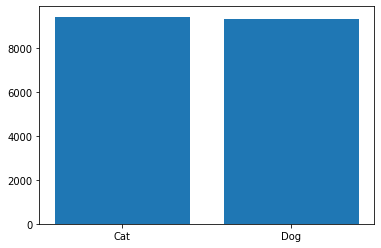

In [86]:
num_classes = 2

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = ds_pet_train.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

plt.bar(["Cat", "Dog"], counts.numpy())
print(counts.numpy())

# **First Sequential model**
This model is partly stolen from the kaggle the helped me set up this notebook. I changed the number of epochs from 3 to 10. I got rid of the convolution that was apart this model to let it be a basic sequential model. 

**Credit**: https://www.kaggle.com/code/mauricioasperti/cats-vs-dogs-image-classification/notebook

In [8]:
#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.
from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)
    
#Creating a model
sequential_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

In [88]:
sequential_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 180, 180, 3)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 97200)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               12441728  
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 12,441,857
Trainable params: 12,441,857
Non-trainable params: 0
_________________________________________

In [89]:
#Compiling the neural network
sequential_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

#Fitting to the model
sequential_history = sequential_model.fit(ds_pet_train, validation_data=ds_pet_test, epochs=10)

Epoch 1/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 2.8366 - accuracy: 0.5270

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 2.7120 - accuracy: 0.5271

436/586 [=====================>........] - ETA: 15s - loss: 2.4343 - accuracy: 0.5302

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 2.4080 - accuracy: 0.5309

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 2.3781 - accuracy: 0.5310

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 2.3616 - accuracy: 0.5306

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 2.1649 - accuracy: 0.5304

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 66s 109ms/step - loss: 2.1652 - accuracy: 0.5304 - val_loss: 1.1364 - val_accuracy: 0.5301
Epoch 2/10
  1/586 [..............................] - ETA: 1:58 - loss: 1.3932 - accuracy: 0.4062

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 1.0049 - accuracy: 0.5444

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 1.0045 - accuracy: 0.5424

436/586 [=====================>........] - ETA: 15s - loss: 0.9905 - accuracy: 0.5425

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.9891 - accuracy: 0.5426

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.9857 - accuracy: 0.5434

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.9831 - accuracy: 0.5439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.9730 - accuracy: 0.5434

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.9728 - accuracy: 0.5435 - val_loss: 1.0725 - val_accuracy: 0.5117
Epoch 3/10
  1/586 [..............................] - ETA: 2:00 - loss: 1.1729 - accuracy: 0.4688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.7691 - accuracy: 0.5496

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


357/586 [=================>............] - ETA: 23s - loss: 0.7718 - accuracy: 0.5508

436/586 [=====================>........] - ETA: 15s - loss: 0.7635 - accuracy: 0.5509

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.7625 - accuracy: 0.5520

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.7607 - accuracy: 0.5534

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.7597 - accuracy: 0.5532

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.7460 - accuracy: 0.5553

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 108ms/step - loss: 0.7459 - accuracy: 0.5553 - val_loss: 0.6996 - val_accuracy: 0.5510
Epoch 4/10
  1/586 [..............................] - ETA: 1:59 - loss: 0.6398 - accuracy: 0.5938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.7009 - accuracy: 0.5551

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6999 - accuracy: 0.5528

436/586 [=====================>........] - ETA: 15s - loss: 0.6978 - accuracy: 0.5507

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6977 - accuracy: 0.5506

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6974 - accuracy: 0.5511

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6973 - accuracy: 0.5515

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6948 - accuracy: 0.5532

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6948 - accuracy: 0.5531 - val_loss: 0.6812 - val_accuracy: 0.5944
Epoch 5/10
  1/586 [..............................] - ETA: 2:05 - loss: 0.6735 - accuracy: 0.5938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.6782 - accuracy: 0.5779

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


357/586 [=================>............] - ETA: 23s - loss: 0.6774 - accuracy: 0.5780

436/586 [=====================>........] - ETA: 15s - loss: 0.6759 - accuracy: 0.5814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6756 - accuracy: 0.5820

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6757 - accuracy: 0.5816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6759 - accuracy: 0.5820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6746 - accuracy: 0.5841

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6746 - accuracy: 0.5840 - val_loss: 0.6522 - val_accuracy: 0.6284
Epoch 6/10
  1/586 [..............................] - ETA: 2:01 - loss: 0.6431 - accuracy: 0.6250

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.6654 - accuracy: 0.5905

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6667 - accuracy: 0.5873

436/586 [=====================>........] - ETA: 15s - loss: 0.6683 - accuracy: 0.5823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6684 - accuracy: 0.5822

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6688 - accuracy: 0.5816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6687 - accuracy: 0.5819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.5824

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6686 - accuracy: 0.5824 - val_loss: 0.6552 - val_accuracy: 0.6200
Epoch 7/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.6627 - accuracy: 0.5905

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6621 - accuracy: 0.5924

436/586 [=====================>........] - ETA: 15s - loss: 0.6621 - accuracy: 0.5923

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6625 - accuracy: 0.5919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6628 - accuracy: 0.5918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6628 - accuracy: 0.5917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.5935

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6618 - accuracy: 0.5935 - val_loss: 0.6393 - val_accuracy: 0.6341
Epoch 8/10
  1/586 [..............................] - ETA: 1:56 - loss: 0.6682 - accuracy: 0.6250

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.6658 - accuracy: 0.5878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6638 - accuracy: 0.5916

436/586 [=====================>........] - ETA: 15s - loss: 0.6645 - accuracy: 0.5905

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6646 - accuracy: 0.5900

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6646 - accuracy: 0.5903

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6646 - accuracy: 0.5896

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.5919

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6634 - accuracy: 0.5918 - val_loss: 0.6558 - val_accuracy: 0.6166
Epoch 9/10
  1/586 [..............................] - ETA: 2:01 - loss: 0.6525 - accuracy: 0.5312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 26s - loss: 0.6647 - accuracy: 0.5960

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6636 - accuracy: 0.5974

436/586 [=====================>........] - ETA: 15s - loss: 0.6636 - accuracy: 0.5969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6640 - accuracy: 0.5961

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6648 - accuracy: 0.5958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6647 - accuracy: 0.5960

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.5961

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6645 - accuracy: 0.5961 - val_loss: 0.6579 - val_accuracy: 0.6019
Epoch 10/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 27s - loss: 0.6655 - accuracy: 0.5926

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 23s - loss: 0.6640 - accuracy: 0.5958

436/586 [=====================>........] - ETA: 15s - loss: 0.6662 - accuracy: 0.5937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 14s - loss: 0.6661 - accuracy: 0.5942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 13s - loss: 0.6661 - accuracy: 0.5937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 12s - loss: 0.6662 - accuracy: 0.5938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.6665 - accuracy: 0.5945

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 64s 109ms/step - loss: 0.6665 - accuracy: 0.5945 - val_loss: 0.6499 - val_accuracy: 0.6070


# **RNN model**
This model modifies the above Sequential model and adds the simple RNN layer. 

In [90]:
rnn_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])
rnn_model.add(layers.Embedding(10000, 32))
rnn_model.add(layers.SimpleRNN(32))

In [91]:
rnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_16 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 180, 180, 3)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 97200)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               12441728  
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
_________________________________________________________________
embedding_2 (Embedding)      (None, 1, 32)           

In [92]:
#Compiling the neural network
rnn_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

#Fitting to the model
rnn_history = rnn_model.fit(ds_pet_train, validation_data=ds_pet_test, epochs=10)

Epoch 1/10
  1/586 [..............................] - ETA: 15:23 - loss: 5.1574 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.7467 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.7415 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.6959 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.6935 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.6877 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.6849 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.6656 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 58s 96ms/step - loss: 3.6653 - accuracy: 0.0000e+00 - val_loss: 3.6062 - val_accuracy: 0.0000e+00
Epoch 2/10
  1/586 [..............................] - ETA: 1:53 - loss: 3.9867 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5658 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5645 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5523 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5458 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5406 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.5405 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5474 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 57s 96ms/step - loss: 3.5471 - accuracy: 0.0000e+00 - val_loss: 3.5872 - val_accuracy: 0.0000e+00
Epoch 3/10
  1/586 [..............................] - ETA: 1:50 - loss: 4.3536 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5511 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5516 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5388 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


444/586 [=====================>........] - ETA: 12s - loss: 3.5351 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5327 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.5271 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5387 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 96ms/step - loss: 3.5383 - accuracy: 0.0000e+00 - val_loss: 3.5819 - val_accuracy: 0.0000e+00
Epoch 4/10
  1/586 [..............................] - ETA: 1:48 - loss: 4.7390 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5407 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5528 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5351 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5346 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5260 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.5255 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5337 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 96ms/step - loss: 3.5344 - accuracy: 0.0000e+00 - val_loss: 3.5786 - val_accuracy: 0.0000e+00
Epoch 5/10
  1/586 [..............................] - ETA: 1:50 - loss: 3.7485 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5396 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5509 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5318 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5286 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5279 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 10s - loss: 3.5274 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5313 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 96ms/step - loss: 3.5316 - accuracy: 0.0000e+00 - val_loss: 3.5761 - val_accuracy: 0.0000e+00
Epoch 6/10
  1/586 [..............................] - ETA: 1:52 - loss: 2.9597 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5386 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5427 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5342 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5283 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5210 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 10s - loss: 3.5206 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5299 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 95ms/step - loss: 3.5296 - accuracy: 0.0000e+00 - val_loss: 3.5743 - val_accuracy: 0.0000e+00
Epoch 7/10
  1/586 [..............................] - ETA: 1:50 - loss: 4.1353 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5483 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5416 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5312 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5262 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5220 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.5207 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5287 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 95ms/step - loss: 3.5280 - accuracy: 0.0000e+00 - val_loss: 3.5730 - val_accuracy: 0.0000e+00
Epoch 8/10
  1/586 [..............................] - ETA: 1:49 - loss: 3.3508 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5328 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5389 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5284 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5261 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5197 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 11s - loss: 3.5226 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5260 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 96ms/step - loss: 3.5270 - accuracy: 0.0000e+00 - val_loss: 3.5722 - val_accuracy: 0.0000e+00
Epoch 9/10
  1/586 [..............................] - ETA: 1:52 - loss: 3.7408 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5376 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5426 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5264 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5250 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5208 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 10s - loss: 3.5186 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5265 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 96ms/step - loss: 3.5265 - accuracy: 0.0000e+00 - val_loss: 3.5718 - val_accuracy: 0.0000e+00
Epoch 10/10
  1/586 [..............................] - ETA: 1:51 - loss: 3.1552 - accuracy: 0.0000e+00

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/586 [===============>..............] - ETA: 23s - loss: 3.5379 - accuracy: 0.0000e+00

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


358/586 [=================>............] - ETA: 20s - loss: 3.5341 - accuracy: 0.0000e+00

436/586 [=====================>........] - ETA: 13s - loss: 3.5221 - accuracy: 0.0000e+00

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


445/586 [=====================>........] - ETA: 12s - loss: 3.5243 - accuracy: 0.0000e+00

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


457/586 [======================>.......] - ETA: 11s - loss: 3.5193 - accuracy: 0.0000e+00

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


464/586 [======================>.......] - ETA: 10s - loss: 3.5171 - accuracy: 0.0000e+00

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 3.5262 - accuracy: 0.0000e+00

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 56s 95ms/step - loss: 3.5262 - accuracy: 0.0000e+00 - val_loss: 3.5718 - val_accuracy: 0.0000e+00


# **CNN Model**
This model is a combination of Professor mazidi's model in her github and the model from the aformentioned kaggle model. I added in convolution here for CNN. 

**Credit:** https://github.com/kjmazidi/Machine_Learning_2nd_edition/blob/master/Part_7_Neural_Networks/Keras_CNN_Example_MNIST.ipynb

In [9]:
cnn_model = tf.keras.models.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


In [94]:
cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_17 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 118336)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 118336)          

In [10]:
cnn_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

#Fitting to the model
cnn_history = cnn_model.fit(ds_pet_train, validation_data=ds_pet_test, epochs=10)

Epoch 1/10


2022-12-05 05:30:50.129855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
2022-12-05 05:30:51.348870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


329/586 [===============>..............] - ETA: 11s - loss: 0.6171 - accuracy: 0.6503

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.6108 - accuracy: 0.6563

439/586 [=====================>........] - ETA: 6s - loss: 0.5985 - accuracy: 0.6679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 5s - loss: 0.5976 - accuracy: 0.6691

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 5s - loss: 0.5969 - accuracy: 0.6709

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 5s - loss: 0.5958 - accuracy: 0.6718

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.6848

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 38s 52ms/step - loss: 0.5832 - accuracy: 0.6848 - val_loss: 0.5370 - val_accuracy: 0.7386
Epoch 2/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.4894 - accuracy: 0.7652

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


362/586 [=================>............] - ETA: 9s - loss: 0.4858 - accuracy: 0.7668

440/586 [=====================>........] - ETA: 6s - loss: 0.4802 - accuracy: 0.7705

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 5s - loss: 0.4797 - accuracy: 0.7707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 5s - loss: 0.4785 - accuracy: 0.7714

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 4s - loss: 0.4789 - accuracy: 0.7713

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.7711

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 30s 50ms/step - loss: 0.4786 - accuracy: 0.7709 - val_loss: 0.4674 - val_accuracy: 0.7745
Epoch 3/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 10s - loss: 0.4241 - accuracy: 0.8083

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.4228 - accuracy: 0.8089

439/586 [=====================>........] - ETA: 6s - loss: 0.4188 - accuracy: 0.8103

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 5s - loss: 0.4184 - accuracy: 0.8101

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 5s - loss: 0.4202 - accuracy: 0.8092

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 4s - loss: 0.4207 - accuracy: 0.8090

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.4171 - accuracy: 0.8099

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 30s 50ms/step - loss: 0.4179 - accuracy: 0.8093 - val_loss: 0.4409 - val_accuracy: 0.7950
Epoch 4/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.3766 - accuracy: 0.8331

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


362/586 [=================>............] - ETA: 9s - loss: 0.3738 - accuracy: 0.8343

440/586 [=====================>........] - ETA: 5s - loss: 0.3722 - accuracy: 0.8340

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.3715 - accuracy: 0.8345

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.3712 - accuracy: 0.8349

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.3714 - accuracy: 0.8348

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8375

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 48ms/step - loss: 0.3674 - accuracy: 0.8374 - val_loss: 0.4856 - val_accuracy: 0.7836
Epoch 5/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 9s - loss: 0.3287 - accuracy: 0.8573 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 8s - loss: 0.3251 - accuracy: 0.8590

439/586 [=====================>........] - ETA: 5s - loss: 0.3218 - accuracy: 0.8597

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 5s - loss: 0.3211 - accuracy: 0.8599

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 4s - loss: 0.3207 - accuracy: 0.8600

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 4s - loss: 0.3217 - accuracy: 0.8593

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8622

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 49ms/step - loss: 0.3191 - accuracy: 0.8622 - val_loss: 0.5142 - val_accuracy: 0.7785
Epoch 6/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 9s - loss: 0.2885 - accuracy: 0.8786 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


362/586 [=================>............] - ETA: 8s - loss: 0.2869 - accuracy: 0.8784

439/586 [=====================>........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


447/586 [=====================>........] - ETA: 5s - loss: 0.2836 - accuracy: 0.8803

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


458/586 [======================>.......] - ETA: 5s - loss: 0.2839 - accuracy: 0.8801

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


466/586 [======================>.......] - ETA: 4s - loss: 0.2832 - accuracy: 0.8806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8803

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 48ms/step - loss: 0.2826 - accuracy: 0.8804 - val_loss: 0.4765 - val_accuracy: 0.7909
Epoch 7/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.2551 - accuracy: 0.8941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


362/586 [=================>............] - ETA: 8s - loss: 0.2550 - accuracy: 0.8948

440/586 [=====================>........] - ETA: 5s - loss: 0.2514 - accuracy: 0.8957

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.2524 - accuracy: 0.8954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 4s - loss: 0.2529 - accuracy: 0.8948

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.2532 - accuracy: 0.8952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8963

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 48ms/step - loss: 0.2508 - accuracy: 0.8964 - val_loss: 0.5140 - val_accuracy: 0.7909
Epoch 8/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 9s - loss: 0.2259 - accuracy: 0.9062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 8s - loss: 0.2258 - accuracy: 0.9063

440/586 [=====================>........] - ETA: 5s - loss: 0.2207 - accuracy: 0.9088

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.2205 - accuracy: 0.9090

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 4s - loss: 0.2218 - accuracy: 0.9084

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.2226 - accuracy: 0.9081

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


584/586 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9096

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 49ms/step - loss: 0.2199 - accuracy: 0.9095 - val_loss: 0.5739 - val_accuracy: 0.7841
Epoch 9/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 9s - loss: 0.2038 - accuracy: 0.9133 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 8s - loss: 0.2038 - accuracy: 0.9128

440/586 [=====================>........] - ETA: 5s - loss: 0.2011 - accuracy: 0.9145

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.2010 - accuracy: 0.9148

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.2007 - accuracy: 0.9147

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.2008 - accuracy: 0.9146

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9136

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 48ms/step - loss: 0.2032 - accuracy: 0.9134 - val_loss: 0.6322 - val_accuracy: 0.7747
Epoch 10/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 10s - loss: 0.1834 - accuracy: 0.9232

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.1830 - accuracy: 0.9231

440/586 [=====================>........] - ETA: 5s - loss: 0.1829 - accuracy: 0.9226

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.1830 - accuracy: 0.9223

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.1826 - accuracy: 0.9226

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.1826 - accuracy: 0.9227

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


583/586 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9240

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 29s 48ms/step - loss: 0.1795 - accuracy: 0.9242 - val_loss: 0.5834 - val_accuracy: 0.7864


# **Transfer Learning**
This model follows the an example a Tensorflow Tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing

*I had no idea the example tutorial the professor supplied used a similar cats and dogs data set that I was using when I first started the assignment.*

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(ds_pet_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


(32, 6, 6, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 90, 90, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
inputs = tf.keras.Input(shape=input_shape) 
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0     

In [20]:
loss0, accuracy0 = model.evaluate(ds_pet_test)

  2/147 [..............................] - ETA: 7s - loss: 0.5469 - accuracy: 0.6406  

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 11/147 [=>............................] - ETA: 5s - loss: 0.5811 - accuracy: 0.6250

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 47/147 [========>.....................] - ETA: 4s - loss: 0.5773 - accuracy: 0.6543

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 63/147 [===========>..................] - ETA: 3s - loss: 0.5732 - accuracy: 0.6691

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


101/147 [===================>..........] - ETA: 1s - loss: 0.5781 - accuracy: 0.6593

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


109/147 [=====================>........] - ETA: 1s - loss: 0.5756 - accuracy: 0.6614

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


147/147 [==============================] - 8s 40ms/step - loss: 0.5829 - accuracy: 0.6576


In [21]:
transfer_history = model.fit(ds_pet_train, validation_data=ds_pet_test, epochs=10)

Epoch 1/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/586 [===============>..............] - ETA: 11s - loss: 0.3195 - accuracy: 0.8470

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 10s - loss: 0.3073 - accuracy: 0.8546

438/586 [=====================>........] - ETA: 6s - loss: 0.2844 - accuracy: 0.8672

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 6s - loss: 0.2831 - accuracy: 0.8681

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.2795 - accuracy: 0.8702

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


466/586 [======================>.......] - ETA: 5s - loss: 0.2783 - accuracy: 0.8708

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.8838

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 34s 54ms/step - loss: 0.2546 - accuracy: 0.8838 - val_loss: 0.1076 - val_accuracy: 0.9579
Epoch 2/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 11s - loss: 0.1392 - accuracy: 0.9441

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 10s - loss: 0.1371 - accuracy: 0.9458

440/586 [=====================>........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9462

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 6s - loss: 0.1342 - accuracy: 0.9466

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.1332 - accuracy: 0.9469

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 5s - loss: 0.1330 - accuracy: 0.9470

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9474

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.1310 - accuracy: 0.9475 - val_loss: 0.0784 - val_accuracy: 0.9699
Epoch 3/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/586 [===============>..............] - ETA: 11s - loss: 0.1147 - accuracy: 0.9550

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.1121 - accuracy: 0.9559

440/586 [=====================>........] - ETA: 6s - loss: 0.1110 - accuracy: 0.9561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 6s - loss: 0.1104 - accuracy: 0.9564

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.1104 - accuracy: 0.9565

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 5s - loss: 0.1102 - accuracy: 0.9566

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.9569

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.1091 - accuracy: 0.9569 - val_loss: 0.0683 - val_accuracy: 0.9752
Epoch 4/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.1031 - accuracy: 0.9574

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 9s - loss: 0.1032 - accuracy: 0.9579

440/586 [=====================>........] - ETA: 6s - loss: 0.0998 - accuracy: 0.9594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.0999 - accuracy: 0.9593

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.0998 - accuracy: 0.9594

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.0995 - accuracy: 0.9597

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9598

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 31s 53ms/step - loss: 0.0991 - accuracy: 0.9598 - val_loss: 0.0620 - val_accuracy: 0.9769
Epoch 5/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/586 [===============>..............] - ETA: 11s - loss: 0.0984 - accuracy: 0.9599

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.0975 - accuracy: 0.9604

440/586 [=====================>........] - ETA: 6s - loss: 0.0966 - accuracy: 0.9603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.0966 - accuracy: 0.9604

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.0963 - accuracy: 0.9606

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 5s - loss: 0.0962 - accuracy: 0.9606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


585/586 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9607

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.0961 - accuracy: 0.9606 - val_loss: 0.0602 - val_accuracy: 0.9776
Epoch 6/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 10s - loss: 0.0971 - accuracy: 0.9596

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 9s - loss: 0.0965 - accuracy: 0.9599

439/586 [=====================>........] - ETA: 6s - loss: 0.0947 - accuracy: 0.9608

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 6s - loss: 0.0938 - accuracy: 0.9613

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


459/586 [======================>.......] - ETA: 5s - loss: 0.0942 - accuracy: 0.9611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 5s - loss: 0.0939 - accuracy: 0.9614

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


584/586 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9621

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.0920 - accuracy: 0.9622 - val_loss: 0.0573 - val_accuracy: 0.9797
Epoch 7/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/586 [===============>..............] - ETA: 11s - loss: 0.0964 - accuracy: 0.9623

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/586 [=================>............] - ETA: 9s - loss: 0.0952 - accuracy: 0.9623 

440/586 [=====================>........] - ETA: 6s - loss: 0.0922 - accuracy: 0.9635

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 6s - loss: 0.0919 - accuracy: 0.9635

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.0914 - accuracy: 0.9636

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 5s - loss: 0.0913 - accuracy: 0.9637

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


584/586 [============================>.] - ETA: 0s - loss: 0.0896 - accuracy: 0.9634

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.0896 - accuracy: 0.9633 - val_loss: 0.0555 - val_accuracy: 0.9801
Epoch 8/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.0893 - accuracy: 0.9643

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 9s - loss: 0.0892 - accuracy: 0.9636

440/586 [=====================>........] - ETA: 6s - loss: 0.0877 - accuracy: 0.9641

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


448/586 [=====================>........] - ETA: 5s - loss: 0.0872 - accuracy: 0.9644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/586 [======================>.......] - ETA: 5s - loss: 0.0869 - accuracy: 0.9645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


468/586 [======================>.......] - ETA: 4s - loss: 0.0867 - accuracy: 0.9646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9648

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 31s 53ms/step - loss: 0.0854 - accuracy: 0.9648 - val_loss: 0.0539 - val_accuracy: 0.9812
Epoch 9/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 11s - loss: 0.0913 - accuracy: 0.9629

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 9s - loss: 0.0907 - accuracy: 0.9630 

439/586 [=====================>........] - ETA: 6s - loss: 0.0903 - accuracy: 0.9633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 6s - loss: 0.0902 - accuracy: 0.9635

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 5s - loss: 0.0900 - accuracy: 0.9637

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 5s - loss: 0.0903 - accuracy: 0.9637

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


584/586 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9645

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 54ms/step - loss: 0.0883 - accuracy: 0.9645 - val_loss: 0.0532 - val_accuracy: 0.9810
Epoch 10/10


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/586 [===============>..............] - ETA: 10s - loss: 0.0870 - accuracy: 0.9652

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 9s - loss: 0.0859 - accuracy: 0.9655

439/586 [=====================>........] - ETA: 6s - loss: 0.0834 - accuracy: 0.9667

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/586 [=====================>........] - ETA: 5s - loss: 0.0830 - accuracy: 0.9666

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


461/586 [======================>.......] - ETA: 5s - loss: 0.0826 - accuracy: 0.9669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


467/586 [======================>.......] - ETA: 5s - loss: 0.0828 - accuracy: 0.9668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


584/586 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9668

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/586 [==============================] - 32s 53ms/step - loss: 0.0825 - accuracy: 0.9667 - val_loss: 0.0518 - val_accuracy: 0.9816


# **Analysis**
* Sequential:
* loss: 0.6665 
* accuracy: 0.5945
* val_loss: 0.6499 
* val_accuracy: 0.6070

The Sequential model a small margin better than a 50/50 coin toss. Meaning it likely was just guessing and was not really learning the necessary features to distinguish between a cat a dog. This is a difficult problem to overcome, especially because this dataset has roughly equal number of samples of cats and dogs. It is interesting to note that the validation accuracy was higher than the accuracy it self, this is a good thing in general becuase it means the model will generalize well. But in this case it might not mean much. 

* RNN: 
* loss: 3.5262
* accuracy: 0.0000e+00
* val_loss: 3.5718 
* val_accuracy: 0.0000e+00

The RNN model did not work well at all. The less than 0.0000000 percent accuracy means that the model could not even guess correctly.  I seem to think I may have done something wrong for such an abmissal accuracy rating. However, RNN's are not supposed to work well for image classifcation and maybe this is just an expression of how bad they are for it. 

* CNN: 
* loss: 0.1795
* accuracy: 0.9242
* val_loss: 0.5834 
* val_accuracy: 0.7864

The CNN model worked relatively well. CNN is supposed to work well for image classification. It did have a much lower validation accuracy than the normal accuracy. So it will not generalize with the same 92% accuracy. But still a roughly 80% accuracy is not bad. 

* Transfer Learning:
* loss: 0.0825 
* accuracy: 0.9667 
* val_loss: 0.0518
* val_accuracy: 0.9816

The Transfer Learning model worked extremely well with this data. The example was also using a cats and dogs dataset. I can only assume that the example cats and dogs dataset was probably a similar if not the same dataset I found. ImageNet is a powerful model that has been trained classify lots of pictures. So it is not surprise that a state of the art model can get such a high accuracy on such common dataset as cats vs dogs. 